## Import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
preprocess_df = pd.read_csv('../data/preprocessing_data.csv')

## Feature Selection

In [3]:
X = preprocess_df.drop(columns = ['customer_id','location','payment_plan','payment_method','num_playlists_created','churned'])
y = preprocess_df['churned']

## Training set / Validation set / Test set

In [4]:
# 데이터를 70% 훈련 세트, 30% 임시 세트로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 임시 세트를 다시 50%로 나누어 15% 검증 세트, 15% 테스트 세트로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Losgistic Regression

- 모델 정의

In [5]:
losgistic_regression = LogisticRegression()

- GridSearchCV

In [6]:
# 파라미터 그리드 설정
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# GridSearchCV
grid_search = GridSearchCV(losgistic_regression, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print('최적 파라미터 : {}'.format(grid_search.best_params_))

최적 파라미터 : {'C': 0.01, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}


In [18]:
best_model = grid_search.best_estimator_
dump(best_model, 'logistic_model.joblib')

['logistic_model.joblib']

- 테스트 세트 평가

In [19]:
loaded_model = load('logistic_model.joblib')
y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"테스트 데이터 정확도: {accuracy}")

테스트 데이터 정확도: 0.81328


- 성능 평가

In [20]:
y_pred_prob = loaded_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC: {:.4f}".format(roc_auc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.9034
Precision: 0.8231
Recall: 0.8100
F1 Score: 0.8165

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      9132
           1       0.82      0.81      0.82      9618

    accuracy                           0.81     18750
   macro avg       0.81      0.81      0.81     18750
weighted avg       0.81      0.81      0.81     18750



- Confusion Matrix 시각화

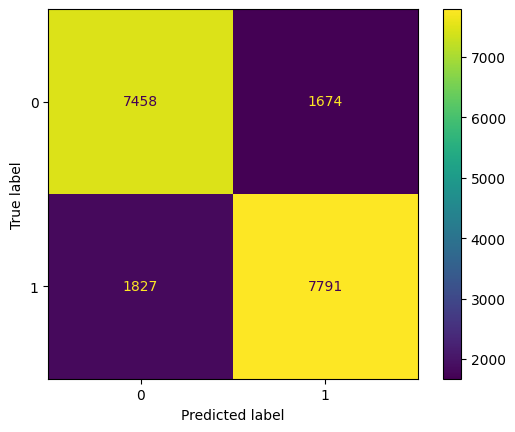

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- ROC Curve 시각화

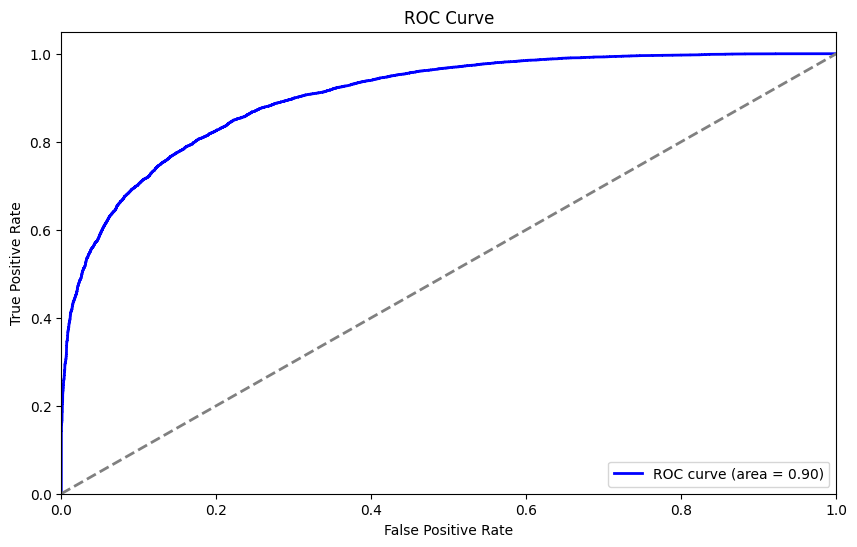

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()